In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb
import plotly.express as px
import plotly.graph_objects as go

from metrics import evaluate

import lightgbm as lgb
import gluonts
from math import sqrt

import shap
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones


from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
from itertools import islice
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook
from bayes_opt import BayesianOptimization


#Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('dark_background')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

plt.style.use('dark_background')

2.3.1


In [8]:
df = pd.read_csv('dash_data_new_2.csv', parse_dates=['flown_date'])

In [9]:
df.head()

flown_date    route         commodity  payload aircraft orig dest  \
0 2019-01-01  SUB-SRG  PERISHABLE GOODS        1      JET  SUB  SRG   
1 2019-01-01  DPS-TMC  PERISHABLE GOODS        9      JET  DPS  TMC   
2 2019-01-01  SUB-PKN     GENERAL CARGO        5      JET  SUB  PKN   
3 2019-01-01  SUB-SMQ     GENERAL CARGO        2      JET  SUB  SMQ   
4 2019-01-02  DPS-BMU     GENERAL CARGO        1      JET  DPS  BMU   

   total_price                            agent iata_code_orig  \
0         2354  PT SURYAGITA NUSARAYA BPN CARGO            SUB   
1       194400                    AGA CARGO DPS            DPS   
2        37915  PT SURYAGITA NUSARAYA SUB CARGO            SUB   
3        24610                 PT DBM SUB CARGO            SUB   
4        13589  PT MANDIRI HANDALAN P SUB CARGO            DPS   

                              orig_airport  orig_lat   orig_long  \
0             Juanda International Airport  -7.37983  112.787003   
1  Ngurah Rai (Bali) International Airport  -8.74817  115.167000   
2             Juanda International Airport  -7.37983  112.787003   
3             Juanda International Airport  -7.37983  112.787003   
4  Ngurah Rai (Bali) International Airport  -8.74817  115.167000   

  iata_code_dest                 dest_airport  dest_lat   dest_long  year  \
0            SRG          Achmad Yani Airport -6.972730  110.375000  2019   
1            TMC            Tambolaka Airport -9.409720  119.244003  2019   
2            PKN             Iskandar Airport -2.705200  111.672997  2019   
3            SMQ        Sampit(Hasan) Airport -2.501389  112.975555  2019   
4            BMU  Muhammad Salahuddin Airport -8.539650  118.686996  2019   

   day month_name  
0    1        Jan  
1    1        Jan  
2    1        Jan  
3    1        Jan  
4    2        Jan

In [10]:
a = '#38BEC9'
b = '#D64545'

## EDA

In [11]:
fig = go.Figure(
    data=[
        go.Scatter(name='payload', 
               x=df.groupby('flown_date', sort=True, as_index=False).sum()['flown_date'], 
               y=df.groupby('flown_date', sort=True, as_index=False).sum()['payload'], 
               yaxis='y', 
               marker_color=b),

    ],
    layout={
        'yaxis': {'title': 'Payload'},
    }
)

# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [12]:
fig = go.Figure(
    data=[
        go.Scatter(name='payload', 
               x=df.groupby('month_name', sort=False, as_index=False).sum()['month_name'], 
               y=df.groupby('month_name', sort=False, as_index=False).sum()['payload'], 
               yaxis='y', 
              marker_color='#38BEC9'),
        go.Scatter(name='sales', 
               x=df.groupby('month_name', sort=False, as_index=False).sum()['month_name'], 
               y=df.groupby('month_name', sort=False, as_index=False).sum()['total_price'], 
               yaxis='y2', 
              marker_color='#D64545')
    ],
    layout={
        'yaxis': {'title': 'Payload'},
        'yaxis2': {'title': 'Sales', 'overlaying': 'y', 'side': 'right'}
    }
)

# Change the bar mode
fig.update_layout(barmode='group', 
                  bargroupgap=0.1,
                 title='Cargo Payload and Sales')
fig.show()

In [13]:
fig = go.Figure(
    data=[
        go.Bar(name='payload', 
               x=df.groupby('agent').sum().sort_values(by='payload', ascending=False).reset_index().head(10)['agent'], 
               y=df.groupby('agent').sum().sort_values(by='payload', ascending=False).reset_index().head(10)['payload'], 
               yaxis='y', 
               marker_color=b),

    ],
    layout={
        'yaxis': {'title': 'Payload'},
    }
)

# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [14]:
fig = go.Figure(
    data=[
        go.Bar(name='payload', 
               x=df.groupby('commodity').sum().sort_values(by='payload', ascending=False).reset_index().head(10)['commodity'], 
               y=df.groupby('commodity').sum().sort_values(by='payload', ascending=False).reset_index().head(10)['payload'], 
               yaxis='y', 
               offsetgroup=1,
               marker_color=a),
        go.Bar(name='sales', 
               x=df.groupby('commodity').sum().sort_values(by='total_price', ascending=False).reset_index().head(10)['commodity'], 
               y=df.groupby('commodity').sum().sort_values(by='total_price', ascending=False).reset_index().head(10)['total_price'], 
               yaxis='y2', 
               offsetgroup=2,
               marker_color=b),

    ],
    layout={
        'yaxis': {'title': 'Payload'},
        'yaxis2': {'title': 'Sales', 'overlaying': 'y', 'side': 'right'}
    }
)

# Change the bar mode
fig.update_layout(barmode='group', bargroupgap=0.1)
fig.show()

In [15]:
fig = go.Figure(
    data=[
        go.Scatter(name='payload', 
               x=df.groupby('day', sort=True, as_index=False).sum()['day'], 
               y=df.groupby('day', sort=False, as_index=False).sum()['payload'], 
               yaxis='y', 
              marker_color='#38BEC9'),
        go.Scatter(name='sales', 
               x=df.groupby('day', sort=True, as_index=False).sum()['day'], 
               y=df.groupby('day', sort=False, as_index=False).sum()['total_price'], 
               yaxis='y2', 
              marker_color='#D64545')
    ],
    layout={
        'yaxis': {'title': 'Payload'},
        'yaxis2': {'title': 'Sales', 'overlaying': 'y', 'side': 'right'},
        'xaxis' : {'title':'Month', 'tickmode':'linear'}
    }
)

# Change the bar mode
fig.update_layout(barmode='group', 
                  bargroupgap=0.1,
                 title='Cargo Payload and Sales')
fig.show()

In [16]:
import plotly.graph_objects as go

labels = df.groupby('commodity').sum().sort_values(by='payload', ascending=False).reset_index().head(10)['commodity']
values = df.groupby('commodity').sum().sort_values(by='payload', ascending=False).reset_index().head(10)['payload']

fig = go.Figure(data=[go.Pie(labels=labels, 
                             values=values, 
                             textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()

In [17]:
df_orig_airport = df[['orig_airport','payload','orig_lat','orig_long']].groupby('orig_airport').agg({'payload':'sum','orig_lat':'first','orig_long':'first'}).sort_values('payload', ascending=False)

In [18]:
fig = px.scatter_mapbox(df_orig_airport, 
                        lat="orig_lat", 
                        lon="orig_long", 
                        color="payload", 
                        mapbox_style='open-street-map', 
                        size='payload', 
                        text='payload',
                        color_continuous_scale=px.colors.cyclical.IceFire, 
                        zoom=3,
                        width=900,
                        height=600)

fig.update_traces(mode='markers', selector=dict(type='scattermapbox'))
# fig.update_traces(hoverlabel=dict(font='Arial'), selector=dict(type='scattermapbox'))

fig.show()

In [19]:
df_dest_airport = df[['dest_airport','payload','dest_lat','dest_long']].groupby('dest_airport').agg({'payload':'sum','dest_lat':'first','dest_long':'first'}).sort_values('payload', ascending=False)

In [20]:
fig = px.scatter_mapbox(df_dest_airport, 
                        lat="dest_lat", 
                        lon="dest_long", 
                        color="payload", 
                        mapbox_style='open-street-map', 
                        size='payload', 
                        text='payload',
                        color_continuous_scale=px.colors.cyclical.IceFire, 
                        zoom=3,
                        width=900,
                        height=600)

fig.update_traces(mode='markers', selector=dict(type='scattermapbox'))
# fig.update_traces(hoverlabel=dict(font='Arial'), selector=dict(type='scattermapbox'))

fig.show()

## Payload Forecasting

In [5]:
df_tmp = df[['flown_date','payload']].copy().groupby('flown_date', as_index=True).sum()

In [6]:
df_tmp

payload
flown_date         
2019-01-01     3667
2019-01-02     9438
2019-01-03    21422
2019-01-04    28581
2019-01-05    30519
...             ...
2019-12-27    24117
2019-12-28    24239
2019-12-29    22079
2019-12-30    13529
2019-12-31    19488

[365 rows x 1 columns]

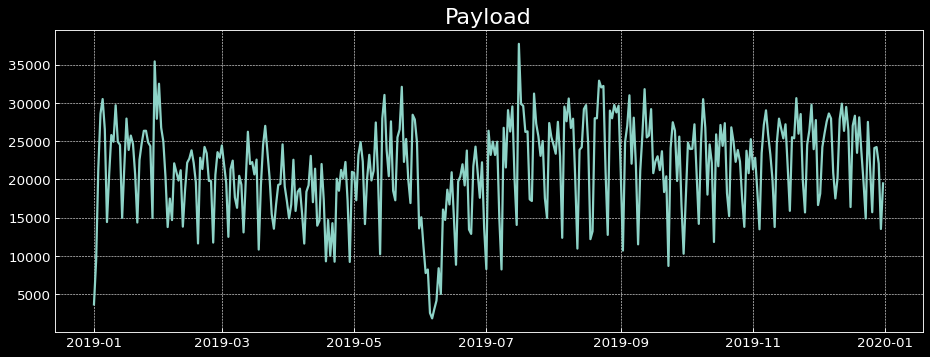

In [94]:
plt.style.use('dark_background')
plt.figure(num=None, figsize=(14, 5), dpi=80, facecolor='black', edgecolor='white')
plt.title('Payload',fontsize=20, color='white')

plt.plot(df_tmp.payload)
pass

<Figure size 4000x1600 with 0 Axes>

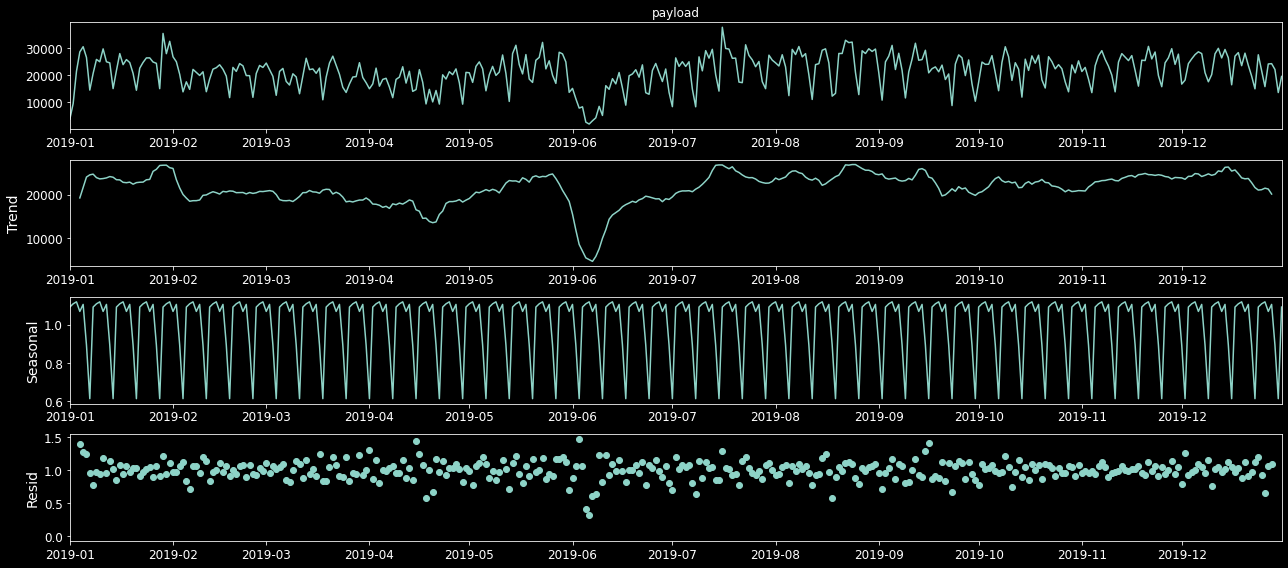

In [8]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='k', edgecolor='k')
series = df_tmp.payload
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pass

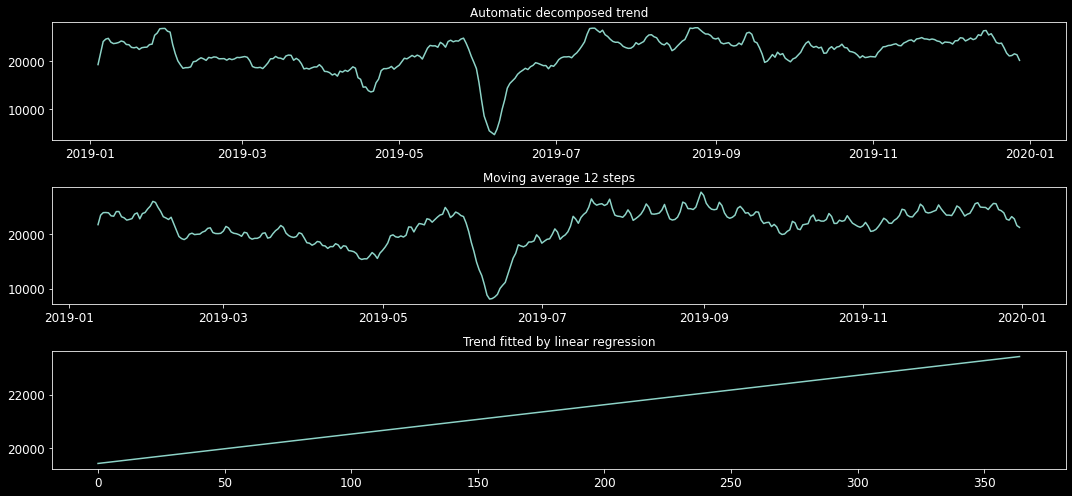

In [9]:
fig = plt.figure(figsize=(15, 7))
layout = (3,2)
pm_ax = plt.subplot2grid(layout, (0,0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1,0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2,0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = df_tmp.payload.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(df_tmp.payload))]
X = np.reshape(X, (len(X), 1))
y = df_tmp.payload.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

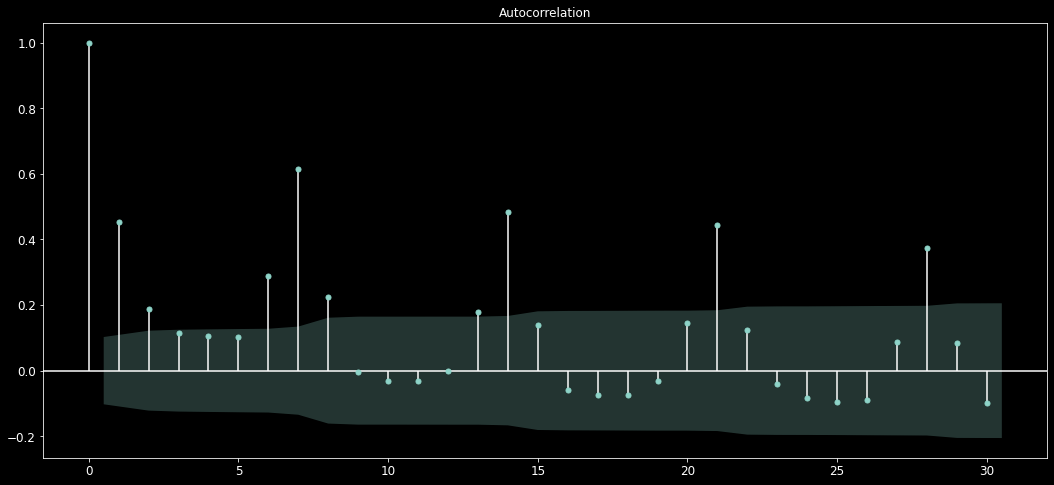

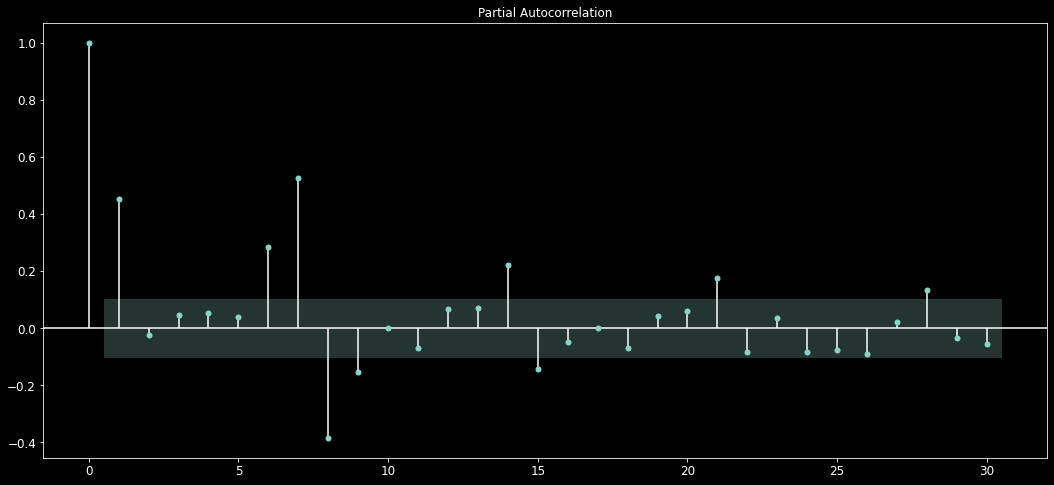

In [10]:
plot_acf(series, lags = 30)
plot_pacf(series, lags = 30)
plt.show()

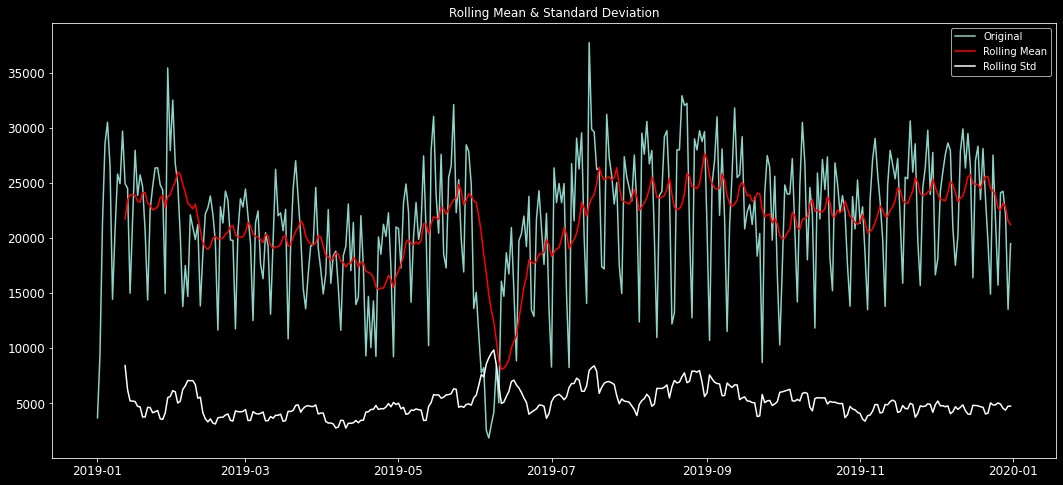

In [11]:
#Determing rolling statistics
rolmean = df_tmp.payload.rolling(window=12).mean()
rolstd = df_tmp.payload.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df_tmp.payload,label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='white', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [12]:
X = df_tmp.payload.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.206565
p-value: 0.019608
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


H0 = data is non stationary

H1 = data is stationary

our p-value is lower than 0.05 so we can reject null hypotesis - our data is stationary

Text(0.5, 1.0, 'Original vs Windowed mean vs Windowed std')

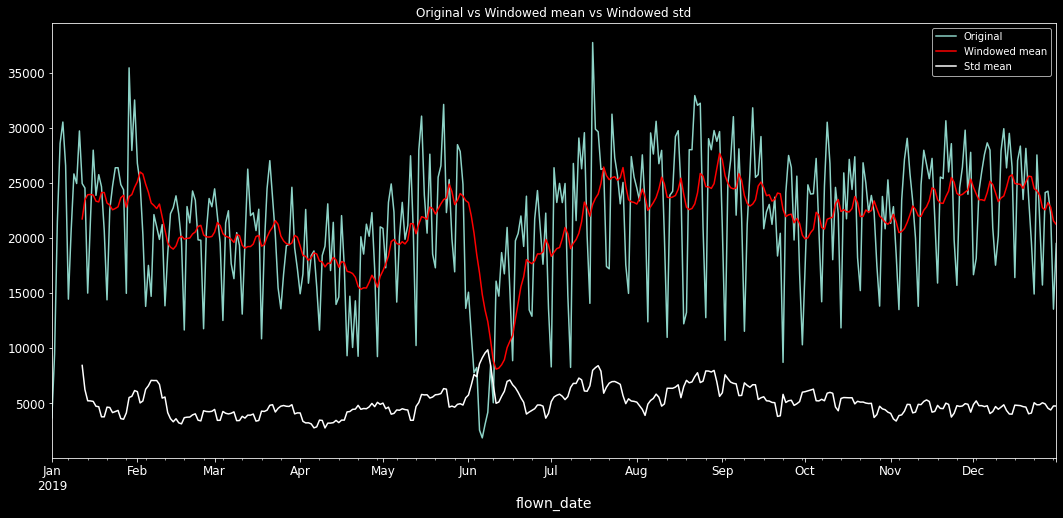

In [13]:
df_tmp.payload.plot(label='Original')
df_tmp.payload.rolling(window=12).mean().plot(color='red', label='Windowed mean')
df_tmp.payload.rolling(window=12).std().plot(color='white', label='Std mean')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')
plt.title('Original vs Windowed mean vs Windowed std', color='white')

### Univariate

In [14]:
resultsDict={}
predictionsDict={}

split_date ='2019-10-01'
df_training = df_tmp.loc[df_tmp.index <= split_date]
df_test = df_tmp.loc[df_tmp.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('training.csv')
df_test.to_csv('test.csv')

274 days of training data 
 91 days of testing data 


### Simple Exponential Smoothing

In [15]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.payload)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.payload, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 91/91 [00:01<00:00, 72.12it/s]


[None, None, None, None]

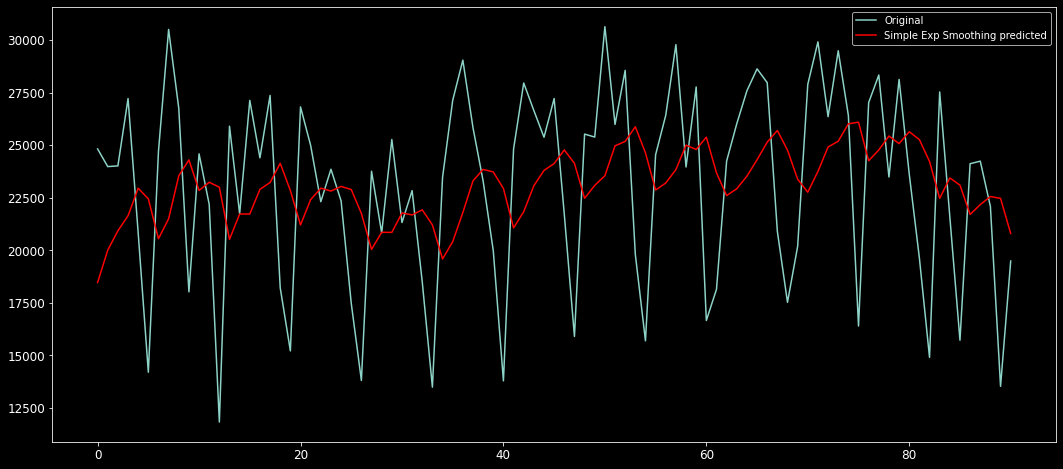

In [16]:
plt.plot(df_test.payload.values, label='Original')
plt.plot(yhat.values,color='red',label='Simple Exp Smoothing predicted')
legend = plt.legend()
plt.style.use('dark_background')
plt.setp(legend.get_texts(), color='w')

### Exponential Smoothing

In [17]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.payload)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.payload, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 91/91 [00:01<00:00, 86.47it/s]


[None, None, None, None]

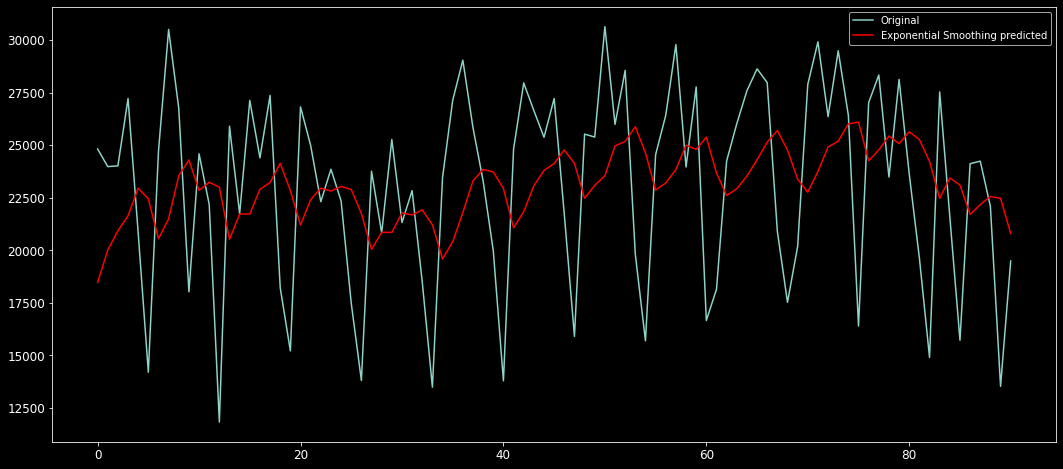

In [18]:
plt.plot(df_test.payload.values, label='Original')
plt.plot(yhat.values,color='red',label='Exponential Smoothing predicted')
legend = plt.legend()
plt.style.use('dark_background')
plt.setp(legend.get_texts(), color='w')

### AR

In [20]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = AR(temp_train.payload)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test.payload, yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 91/91 [00:00<00:00, 281.90it/s]


[None, None, None, None]

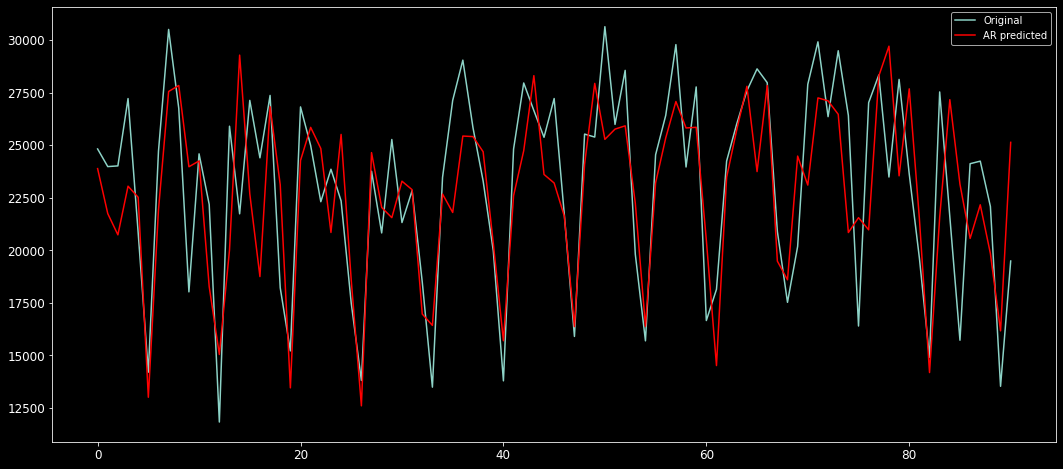

In [21]:
plt.plot(df_test.payload.values, label='Original')
plt.plot(yhat.values,color='red',label='AR predicted')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

### MA

In [22]:
from statsmodels.tsa.arima_model import ARMA
from random import random

index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = ARMA(temp_train.payload, order=(0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test.payload, yhat.values)
predictionsDict['MA'] = yhat.values

100%|██████████| 91/91 [00:04<00:00, 22.61it/s]


[None, None, None, None]

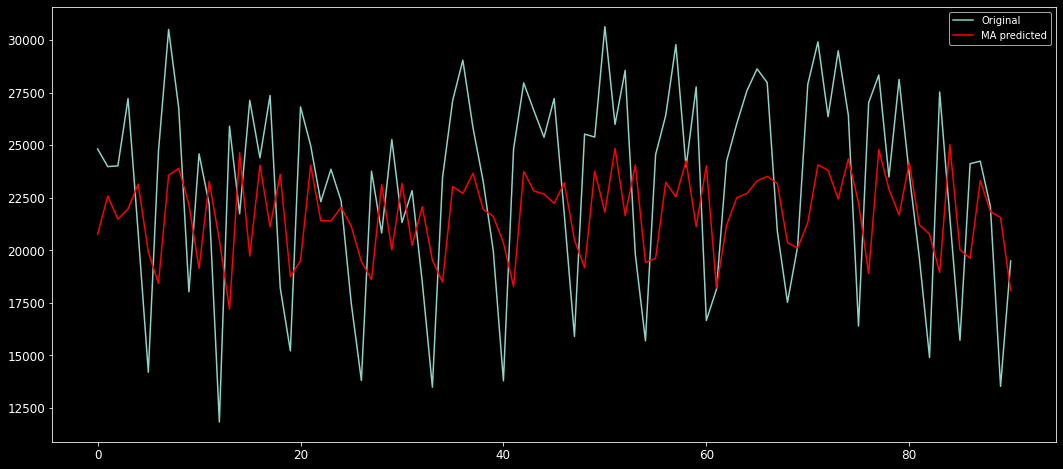

In [23]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.values,color='red',label='MA predicted')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

### ARMA

In [24]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = ARMA(temp_train.payload, order=(1, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['ARMA'] = evaluate(df_test.payload, yhat.values)
predictionsDict['ARMA'] = yhat.values

100%|██████████| 91/91 [00:12<00:00,  7.11it/s]


[None, None, None, None]

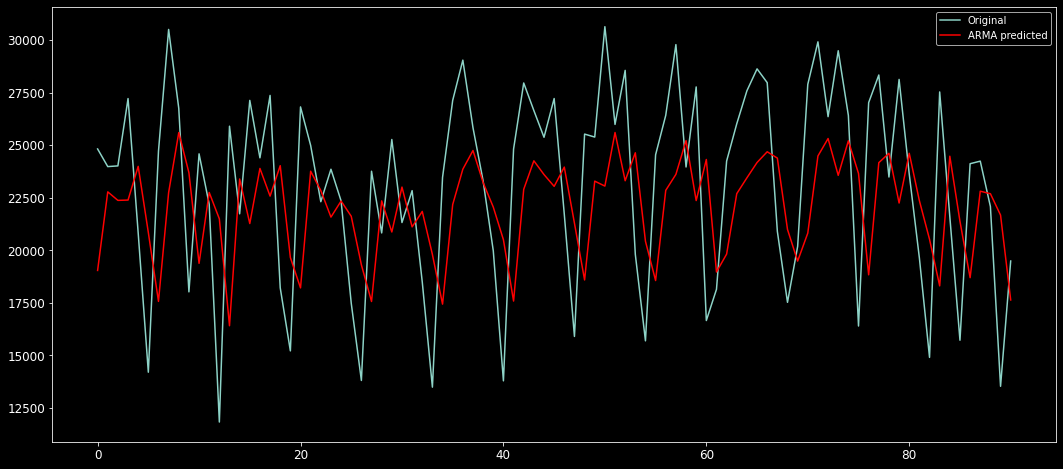

In [25]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.values,color='red',label='ARMA predicted')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

### ARIMA

In [26]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = ARIMA(temp_train.payload, order=(1,0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.payload, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 91/91 [00:07<00:00, 11.84it/s]


[None, None, None, None]

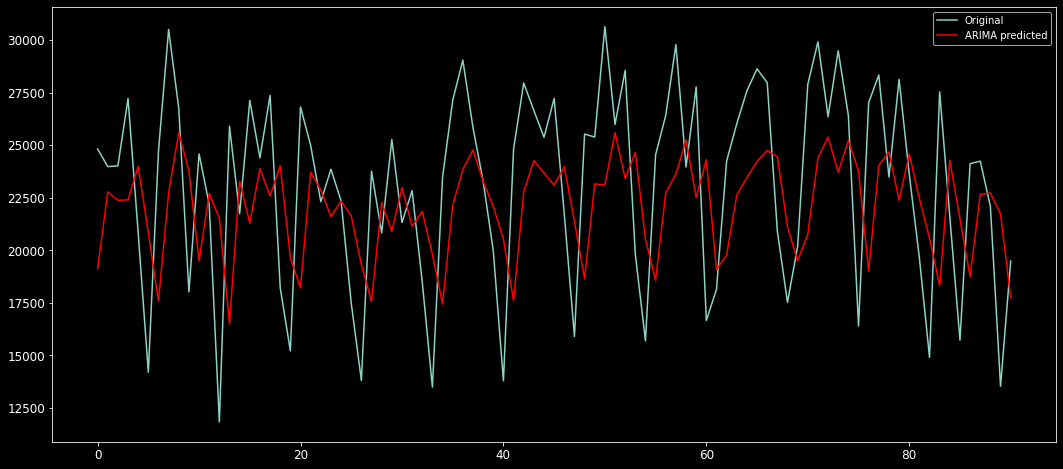

In [27]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.values,color='red',label='ARIMA predicted')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

### AutoSARIMA

In [31]:
autoModel = pm.auto_arima(df_training.payload, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=7, stepwise=True)
autoModel.fit(df_training.payload)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5569.962, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5370.395, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5442.603, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5567.980, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5552.763, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=5350.152, Time=0.74 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=5365.906, Time=1.11 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=5348.269, Time=0.72 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=5470.150, Time=0.07 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=5362.331, Time=1.06 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=5445.916, Time=0.14 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=5345.122, Time=0.70 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=5

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(1, 0, 2, 7),
      suppress_warnings=True, with_intercept=False)

In [43]:
import statsmodels.api as sm
sm.tsa.statespace.SARIMAX

order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = sm.tsa.statespace.SARIMAX(temp_train.payload, order=order, seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoSARIMA {0},{1}'.format(order,seasonalOrder)] = evaluate(df_test.payload, yhat.values)
predictionsDict['AutoSARIMA {0},{1}'.format(order,seasonalOrder)] = yhat.values

100%|██████████| 91/91 [01:27<00:00,  1.04it/s]


[None, None, None, None]

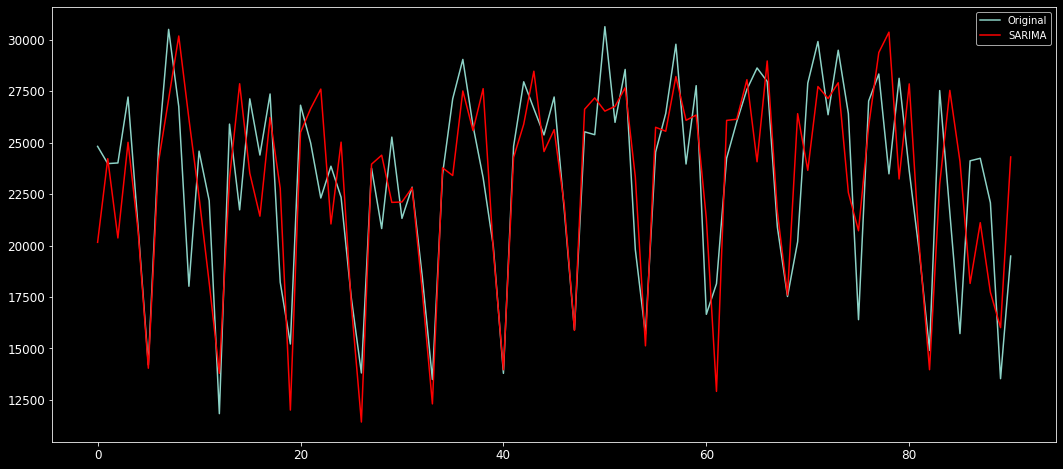

In [44]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMA')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

### Prophet

In [49]:
prophet_training = df_training.rename(columns={'payload': 'y'})
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'payload': 'y'})
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [50]:
prophet = Prophet(
    growth='linear', 
    seasonality_mode='additive',
#     holidays_prior_scale=20, 
    daily_seasonality=False, 
    weekly_seasonality=True, 
    yearly_seasonality=False
    )

In [51]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(df_test.payload, yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values

[None, None, None, None]

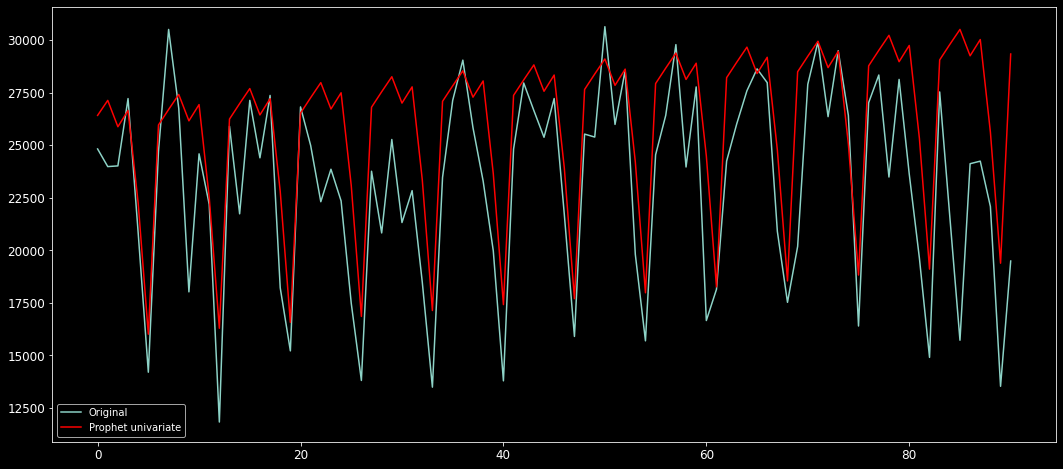

In [52]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.yhat,color='red',label='Prophet univariate')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

In [53]:
dff = df_tmp.copy()

### Multivariate

In [21]:
def create_time_features(dff,target=None):
    """
    Creates time series features from datetime index
    """
    dff['date'] = dff.index
    dff['hour'] = dff['date'].dt.hour
    dff['dayofweek'] = dff['date'].dt.dayofweek
    dff['quarter'] = dff['date'].dt.quarter
    dff['month'] = dff['date'].dt.month
    dff['year'] = dff['date'].dt.year
    dff['dayofyear'] = dff['date'].dt.dayofyear
    dff['sin_day'] = np.sin(dff['dayofyear'])
    dff['cos_day'] = np.cos(dff['dayofyear'])
    dff['dayofmonth'] = dff['date'].dt.day
    dff['weekofyear'] = dff['date'].dt.weekofyear
    X = dff.drop(['date'],axis=1)
    if target:
        y = dff[target]
        X = X.drop([target],axis=1)
        return X, y
    
    return X

In [22]:
split_date ='2019-10-01'
dff_training = dff.loc[df_tmp.index <= split_date]
dff_test = dff.loc[df_tmp.index > split_date]
print(f"{len(dff_training)} days of training data \n {len(dff_test)} days of testing data ")

NameError: name 'dff' is not defined

In [56]:
X_train_df, y_train = create_time_features(dff_training, target='payload')
X_test_df, y_test = create_time_features(dff_test, target='payload')

In [57]:
scaler = StandardScaler()
scaler.fit(X_train_df)

StandardScaler()

In [58]:
X_train = scaler.transform(X_train_df)  
X_test = scaler.transform(X_test_df)

X_train_scaled = pd.DataFrame(X_train,columns=X_train_df.columns)
X_test_scaled = pd.DataFrame(X_test,columns=X_test_df.columns)

In [59]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.payload, yhat)
predictionsDict['Randomforest'] = yhat

In [60]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(X_train, y_train,
       verbose=False) # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.payload, yhat)
predictionsDict['XGBoost'] = yhat

[None, None, None, None]

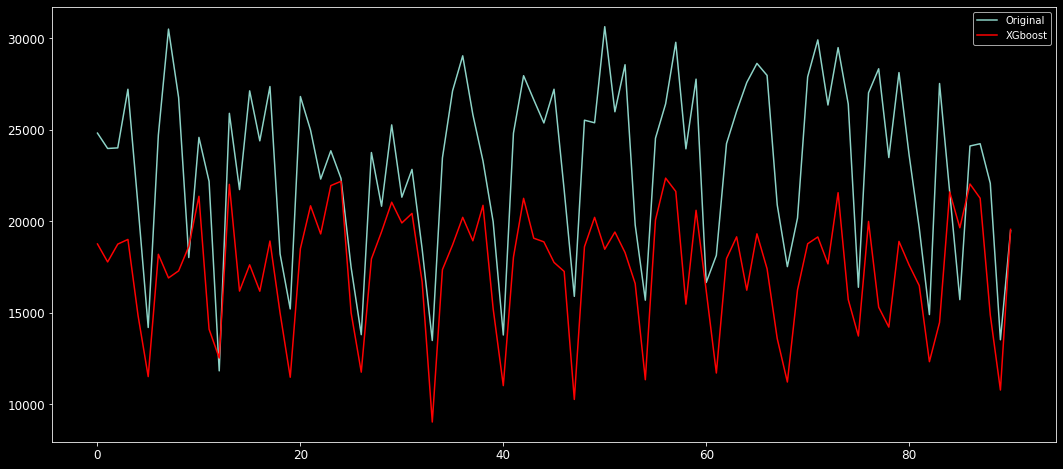

In [61]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat,color='red',label='XGboost')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

In [62]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train,y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.payload, yhat)
predictionsDict['Lightgbm'] = yhat

[None, None, None, None]

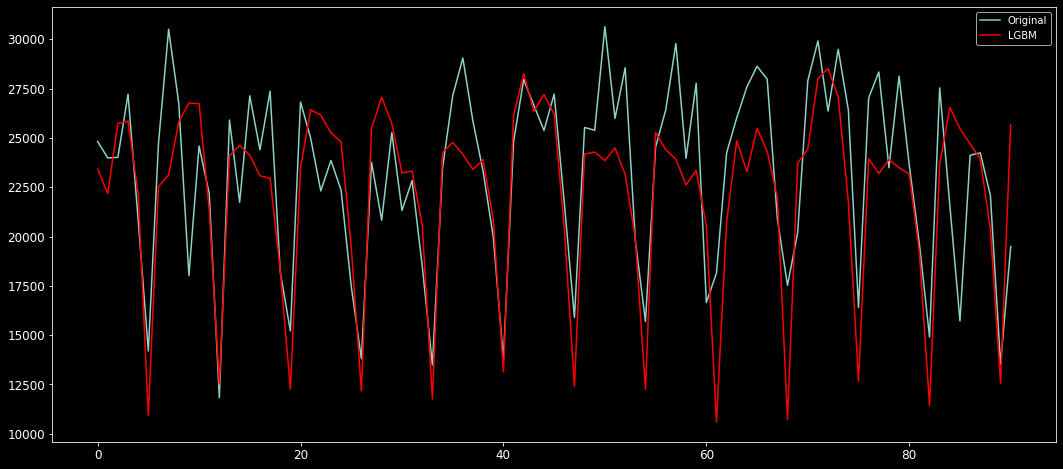

In [63]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat,color='red',label='LGBM')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

In [64]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test.payload, yhat)
predictionsDict['Kneighbors'] = yhat

[None, None, None, None]

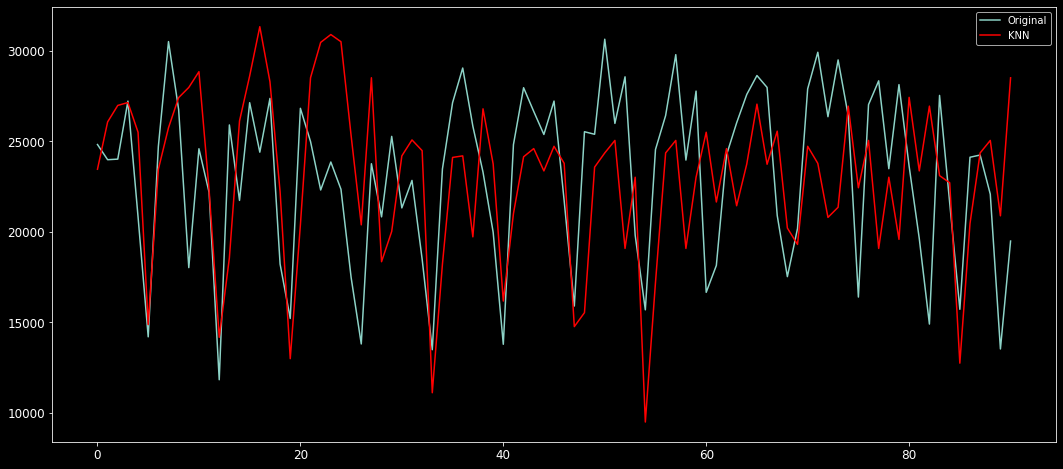

In [65]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat,color='red',label='KNN')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

In [66]:
prophet = Prophet(
    growth='linear', 
    seasonality_mode='multiplicative',
    daily_seasonality=True, 
    ).add_country_holidays(country_name='Indonesia')


for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [67]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet multivariate'] = evaluate(y_test, yhat.yhat.values)
predictionsDict['Prophet multivariate'] = yhat.yhat.values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


[None, None, None, None]

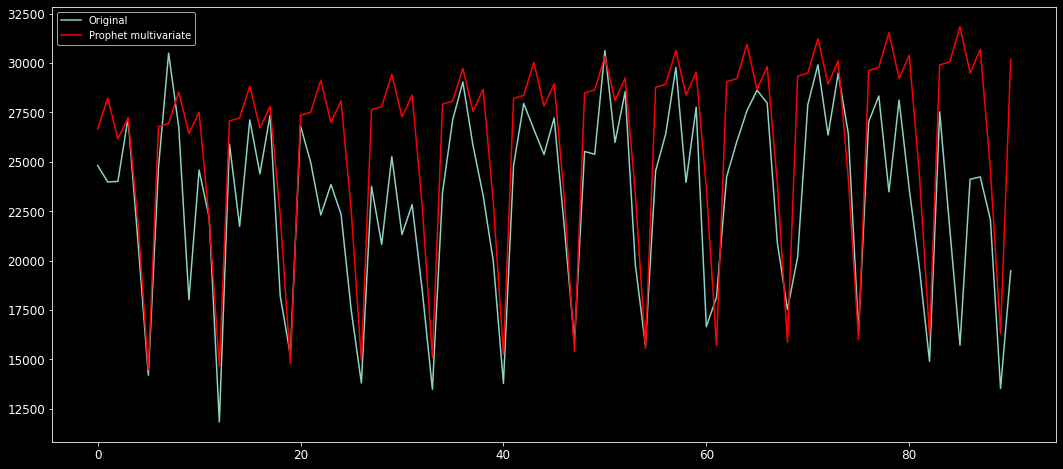

In [68]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.yhat,color='red',label='Prophet multivariate')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

In [69]:
#For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24
def window_data(X,Y,window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x=[]
    y=[]
    for i in range(window-1,len(X)):
        x.append(X[i-window+1:i+1]) 
        y.append(Y[i])
    return np.array(x), np.array(y)
        
#Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w,y_w = window_data(X_w,y_w,window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

#Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [70]:
dropout=0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=X_train_w.shape[-2:],dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

In [71]:
EVALUATION_INTERVAL = 200
EPOCHS = 5

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data, validation_steps=50)#,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support

Epoch 1/5
200/200 [==============================] - 4s 21ms/step - loss: 11993.2344 - val_loss: 4257.7407
Epoch 2/5
200/200 [==============================] - 4s 20ms/step - loss: 4836.5913 - val_loss: 3751.1970
Epoch 3/5
200/200 [==============================] - 4s 19ms/step - loss: 4201.9775 - val_loss: 4909.6396
Epoch 4/5
200/200 [==============================] - 4s 19ms/step - loss: 3463.4302 - val_loss: 5047.3452
Epoch 5/5
200/200 [==============================] - 4s 19ms/step - loss: 2672.9656 - val_loss: 3763.4316


In [72]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1,-1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test,yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

[None, None, None, None]

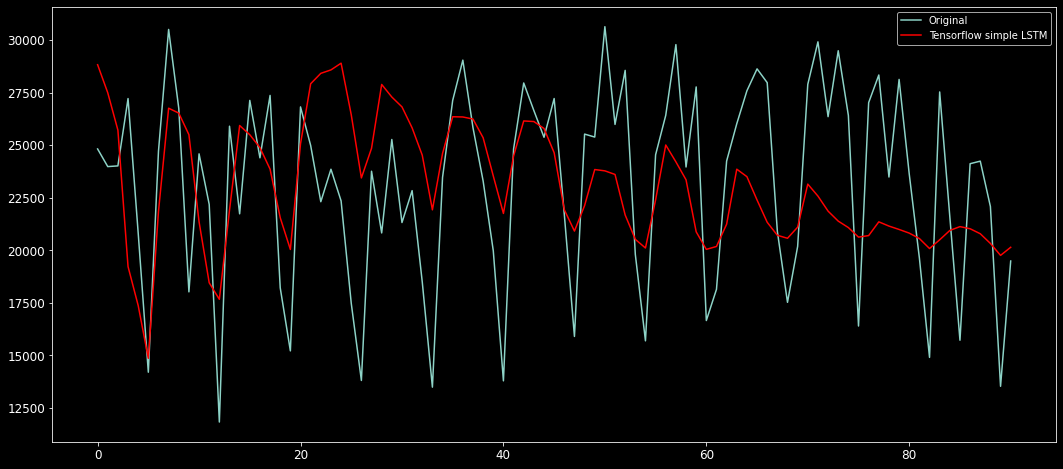

In [73]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat,color='red',label='Tensorflow simple LSTM')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

In [74]:
import pickle

with open('results/scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('results/predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [75]:
import pickle
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

from metrics import evaluate
from plots import bar_metrics


warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

with open('results/scores.pickle', 'rb') as handle:
    resultsDict = pickle.load(handle)

## Load our results from the model notebook
with open('results/predictions.pickle', 'rb') as handle:
    predictionsDict = pickle.load(handle)

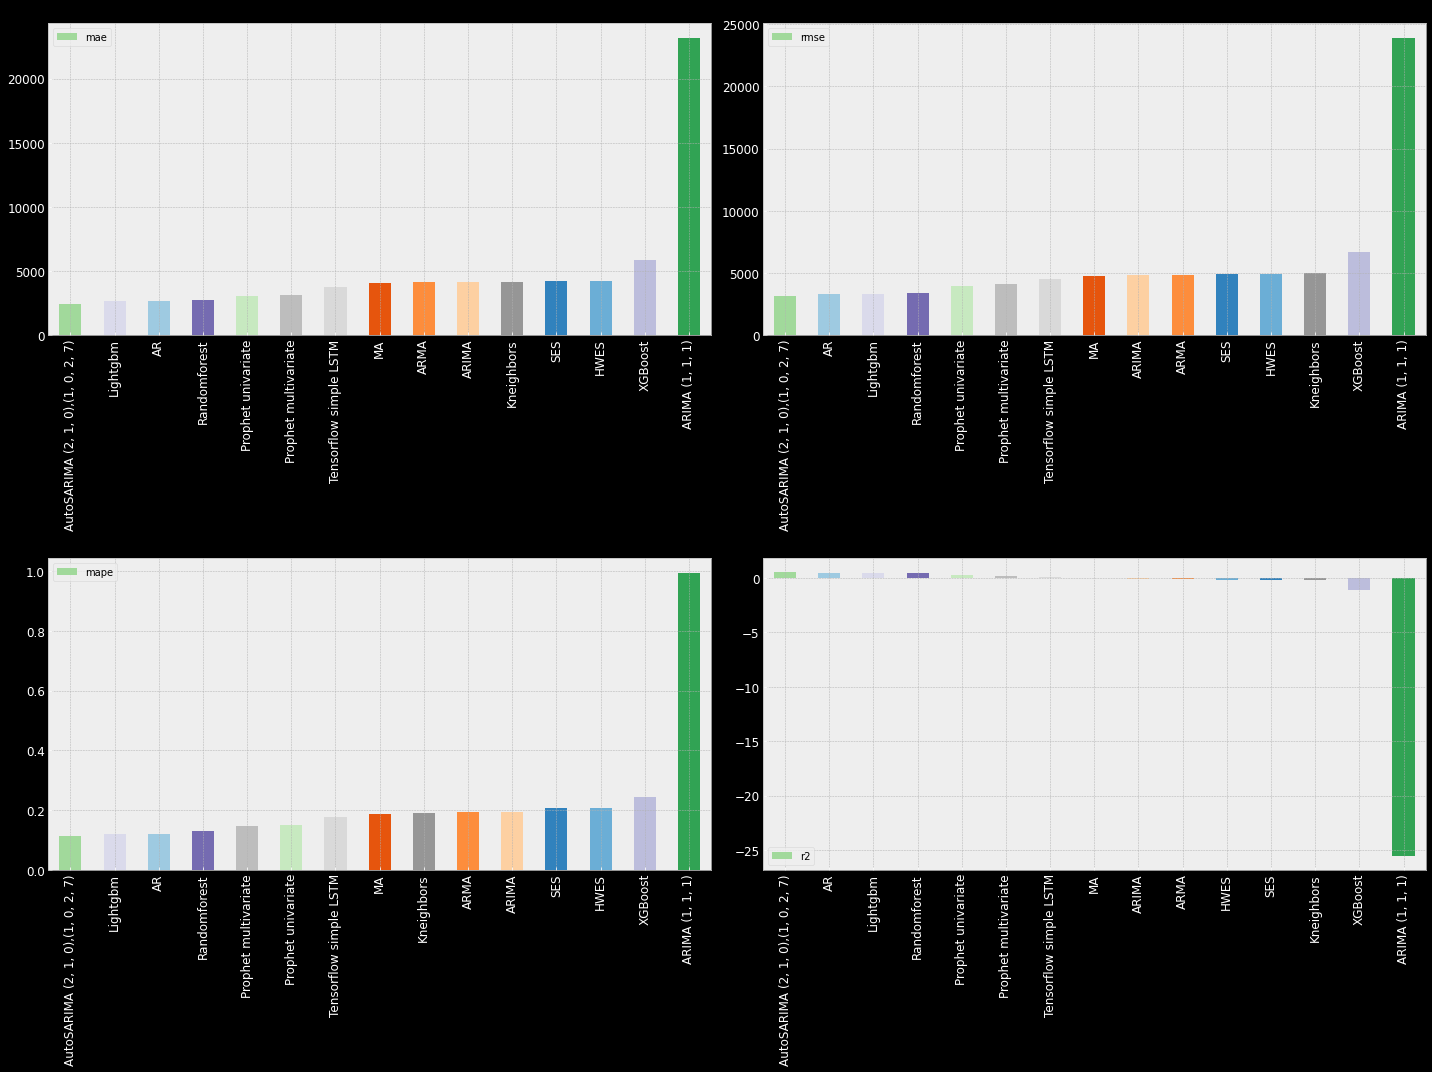

In [76]:
bar_metrics(resultsDict)

### Best Model : AutoSARIMA

We will be focusing more on SARIMA model

In [78]:
autoModel = pm.auto_arima(df_training.payload, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=7, stepwise=True)
autoModel.fit(dff_training.payload)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5569.962, Time=0.26 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5370.395, Time=0.39 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5442.603, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5567.980, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5552.763, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=5350.152, Time=0.72 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=5365.906, Time=1.18 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=5348.269, Time=0.80 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=5470.150, Time=0.08 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=5362.331, Time=1.05 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=5445.916, Time=0.16 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=5345.122, Time=0.69 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=5

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(1, 0, 2, 7),
      suppress_warnings=True, with_intercept=False)

In [80]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(dff_test.payload))):
    temp_train = df_tmp[:len(dff_training)+t]
    model = sm.tsa.statespace.SARIMAX(temp_train.payload, order=order, seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order,seasonalOrder)] = evaluate(df_test.payload, yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(order,seasonalOrder)] = yhat.values

100%|██████████| 91/91 [01:27<00:00,  1.04it/s]


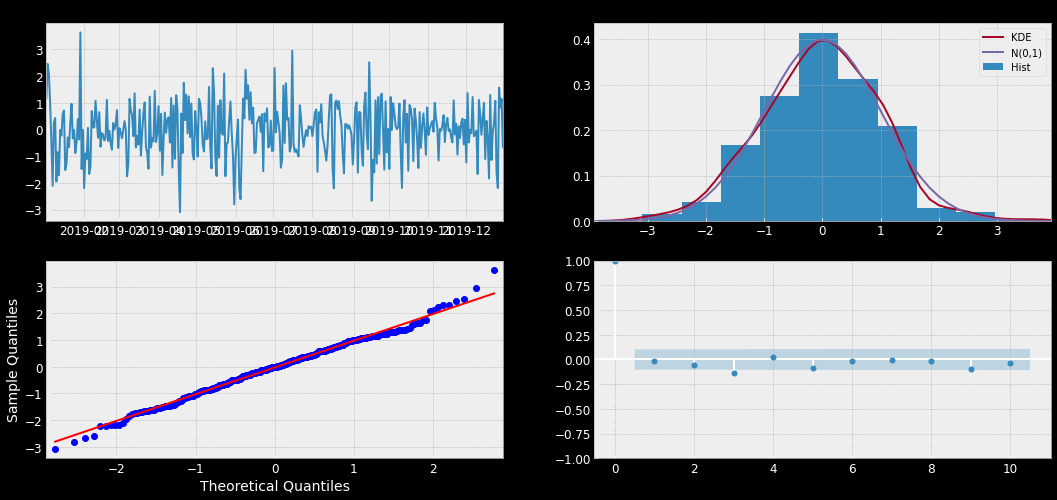

In [84]:
model_fit.plot_diagnostics()
plt.show()

1. Residuals have relatively constant variance
2. model follows normal distribution
3. Model is fitted well
4. The residuals are not auto correlated as there is no significant pattern

In [85]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                payload   No. Observations:                  364
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 7)   Log Likelihood               -3507.445
Date:                                Fri, 11 Dec 2020   AIC                           7026.891
Time:                                        19:20:23   BIC                           7050.257
Sample:                                    01-01-2019   HQIC                          7036.179
                                         - 12-30-2019                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3857      0.048     -8.063      0.000      -0.479      -0.292
ar.L2         -0.1189      0.049     -2.443      0.015      -0.214      -0.024
ar.S.L7        0.9923      0.005    204.968      0.000       0.983       1.002
ma.S.L7       -0.7117      0.052    -13.717      0.000      -0.813      -0.610
ma.S.L14      -0.1300      0.053     -2.463      0.014      -0.234      -0.027
sigma2      1.402e+07   5.04e-10   2.78e+16      0.000     1.4e+07     1.4e+07
===================================================================================
Ljung-Box (Q):                       38.94   Jarque-Bera (JB):                 2.33
Prob(Q):                              0.52   Prob(JB):                         0.31
Heteroskedasticity (H):               0.85   Skew:                            -0.03
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.96e+31. Standard errors may be unstable.
"""

In [89]:
print('Mean Absolute Error on Train Data for SARIMAX: '+str(mean_absolute_error(y_test, yhat))+' KG')

Mean Absolute Error on Train Data for SARIMAX: 2459.1326670975895 KG


In [91]:
mse = ((yhat - y_test) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {} KG'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 10008665.9
The Root Mean Squared Error is 3163.65 KG


Mean Absolute Error (MAE): This measures the absolute average distance between the real data and the predicted data, but it fails to punish large errors in prediction.

Mean Square Error (MSE): This measures the squared average distance between the real data and the predicted data. Here, larger errors are well noted (better than MAE). But the disadvantage is that it also squares up the units of data as well. So, evaluation with different units is not at all justified.

Root Mean Squared Error (RMSE): This is actually the square root of MSE. Also, this metrics solves the problem of squaring the units.

[None, None, None, None]

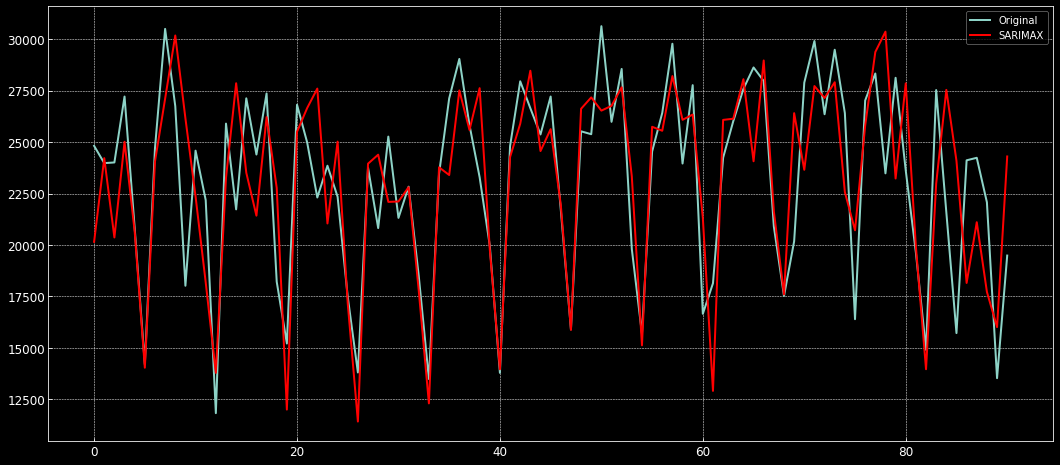

In [96]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMA')
legend = plt.legend()
plt.setp(legend.get_texts(), color='white')

In [97]:
df_predict = pd.DataFrame(data=yhat)

In [98]:
df_predict.index.names = ['flown_date']

In [99]:
df_predict = df_predict.rename(columns={0: 'payload'})

In [100]:
df_predict

payload
flown_date              
2019-10-02  20155.210973
2019-10-03  24220.935224
2019-10-04  20367.148180
2019-10-05  25017.307497
2019-10-06  20657.977433
...                  ...
2019-12-27  18157.109347
2019-12-28  21110.370504
2019-12-29  17725.958003
2019-12-30  16009.290908
2019-12-31  24304.451099

[91 rows x 1 columns]

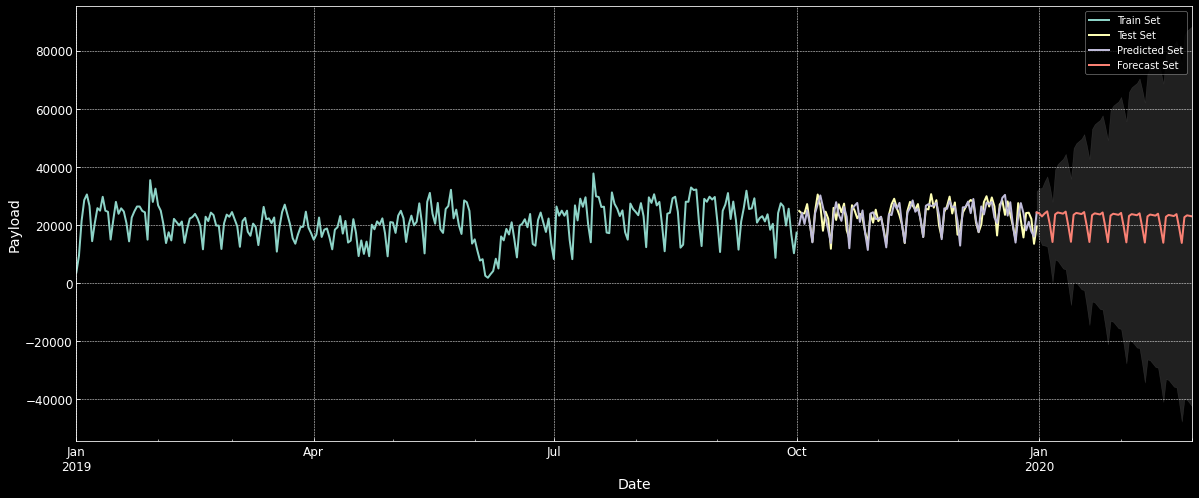

In [105]:
pred_uc = model_fit.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()
ax = df_training.payload.plot(label='Train Set', figsize=(20, 8))
ax2 = df_test.payload.plot(label='Test Set', figsize=(20, 8))
ax3 = df_predict.payload.plot(label='Predicted Set', figsize=(20, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast Set')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='grey', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Payload')
plt.legend()
plt.show()

### Adding Holidays

In [198]:
df_holiday = pd.read_csv('holiday.csv')

In [199]:
df_holiday

Unnamed: 0        date  holiday
0             0  2019-01-01        1
1             1  2019-01-02        0
2             2  2019-01-03        0
3             3  2019-01-04        0
4             4  2019-01-05        0
..          ...         ...      ...
360         360  2019-12-27        0
361         361  2019-12-28        0
362         362  2019-12-29        0
363         363  2019-12-30        0
364         364  2019-12-31        0

[365 rows x 3 columns]

In [200]:
df_holiday = df_holiday.drop(['Unnamed: 0'], axis=1)

In [201]:
df_holiday['date'] = pd.to_datetime(df_holiday['date'])

In [202]:
df_holiday = df_holiday.groupby('date', as_index=True).sum()

In [203]:
df_holiday

holiday
date               
2019-01-01        1
2019-01-02        0
2019-01-03        0
2019-01-04        0
2019-01-05        0
...             ...
2019-12-27        0
2019-12-28        0
2019-12-29        0
2019-12-30        0
2019-12-31        0

[365 rows x 1 columns]

In [210]:
split_date ='2019-10-01'
df_holiday_training = df_sarimax.loc[df_sarimax.index <= split_date]
df_holiday_test = df_sarimax.loc[df_sarimax.index > split_date]
print(f"{len(df_holiday_training)} days of training data \n {len(df_holiday_test)} days of testing data ")

274 days of training data 
 91 days of testing data 


In [211]:
autoModel = pm.auto_arima(df_training.payload, 
                          trace=True, 
                          error_action='ignore', 
                          suppress_warnings=True, 
                          seasonal=True,
                          m=7, 
                          stepwise=True,
                         exogenous=df_holiday_training[['holiday']])
autoModel.fit(dff_training.payload)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5571.346, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5375.940, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5446.764, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=6828.751, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5555.274, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=5356.518, Time=0.81 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=5372.398, Time=1.50 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=5326.999, Time=1.10 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=5473.001, Time=0.14 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=5354.095, Time=1.47 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=5450.131, Time=0.21 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=5390.114, Time=2.18 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=5348.447, Time=0.90 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : 

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(1, 0, 2, 7),
      suppress_warnings=True, with_intercept=False)

In [216]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(dff_test.payload))):
    temp_train = df_tmp[:len(dff_training)+t]
    model = sm.tsa.statespace.SARIMAX(temp_train.payload, 
                                      order=order, 
                                      seasonal_order=seasonalOrder, 
                                      exogenous=df_holiday[['holiday']], 
                                      initialization='approximate_diffuse')
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order,seasonalOrder)] = evaluate(df_test.payload, yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(order,seasonalOrder)] = yhat.values

100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


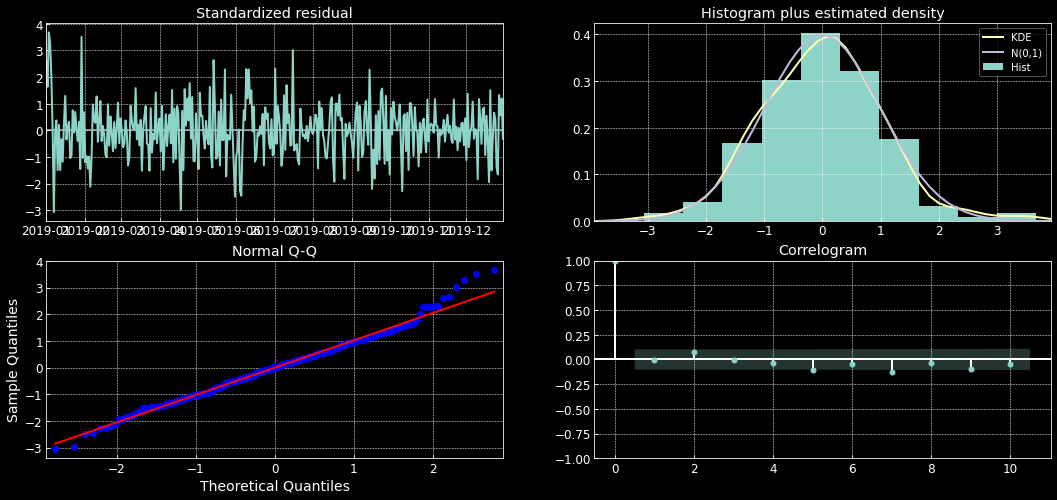

In [217]:
model_fit.plot_diagnostics()
plt.show()

In [218]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                payload   No. Observations:                  364
Model:             SARIMAX(3, 1, 0)x(1, 0, [1, 2], 7)   Log Likelihood               -3526.798
Date:                                Fri, 11 Dec 2020   AIC                           7067.595
Time:                                        20:54:17   BIC                           7094.876
Sample:                                    01-01-2019   HQIC                          7078.438
                                         - 12-30-2019                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3611      0.042     -8.526      0.000      -0.444      -0.278
ar.L2         -0.2090      0.048     -4.372      0.000      -0.303      -0.115
ar.L3         -0.1553      0.051     -3.024      0.002      -0.256      -0.055
ar.S.L7        1.0000      0.011     89.149      0.000       0.978       1.022
ma.S.L7       -0.5999      0.049    -12.274      0.000      -0.696      -0.504
ma.S.L14      -0.3102      0.051     -6.048      0.000      -0.411      -0.210
sigma2       1.44e+07   8.14e-10   1.77e+16      0.000    1.44e+07    1.44e+07
===================================================================================
Ljung-Box (Q):                       47.74   Jarque-Bera (JB):                12.01
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.23
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.44e+30. Standard errors may be unstable.
"""

In [219]:
print('Mean Absolute Error on Train Data for SARIMAX: '+str(mean_absolute_error(y_test, yhat))+' KG')

Mean Absolute Error on Train Data for SARIMAX: 2508.5121342344014 KG


In [220]:
mse = ((yhat - y_test) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {} KG'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 9996893.17
The Root Mean Squared Error is 3161.79 KG


[None, None, None, None]

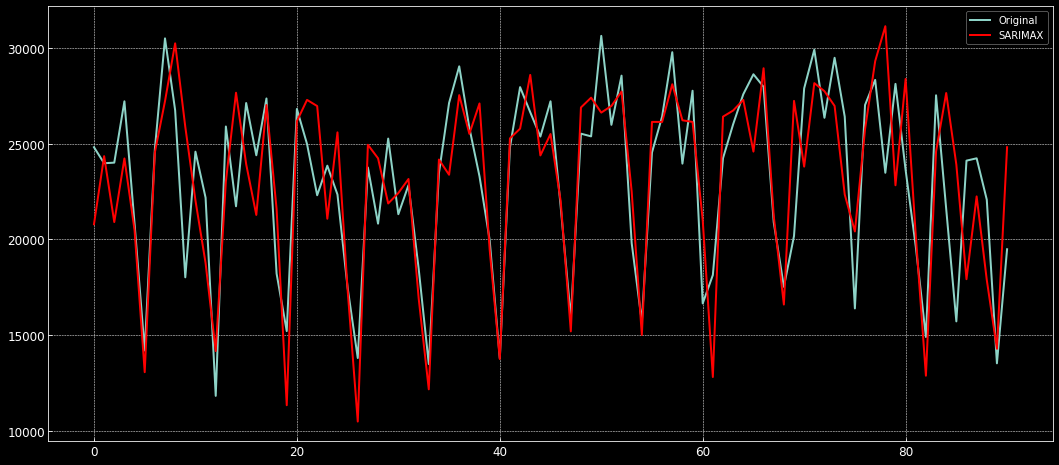

In [221]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMAX')
legend = plt.legend()
plt.setp(legend.get_texts(), color='white')

In [222]:
df_predict = pd.DataFrame(data=yhat)

In [223]:
df_predict.index.names = ['flown_date']

In [224]:
df_predict = df_predict.rename(columns={0: 'payload'})

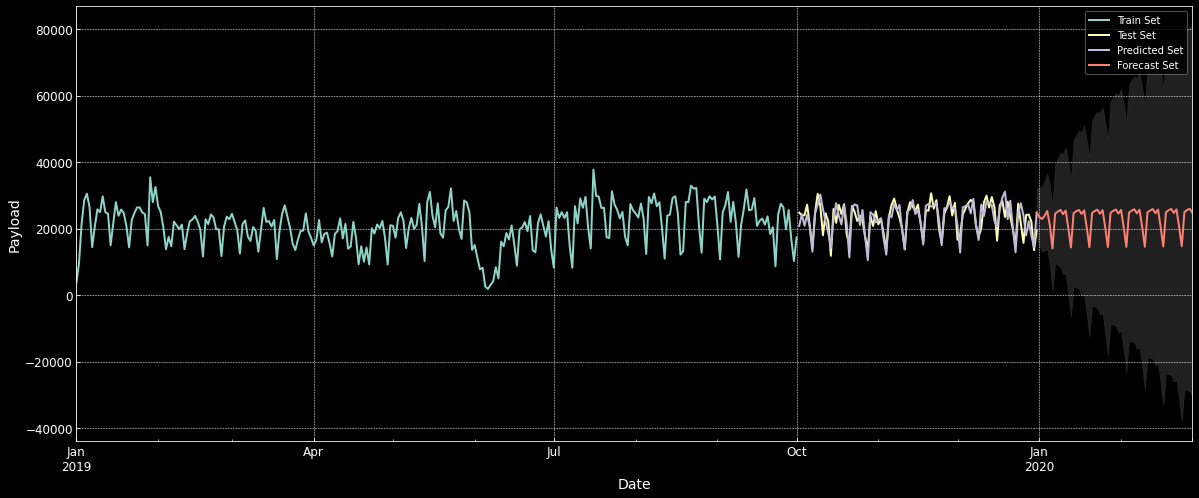

In [228]:
pred_uc = model_fit.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()
ax = df_training.payload.plot(label='Train Set', figsize=(20, 8))
ax2 = df_test.payload.plot(label='Test Set', figsize=(20, 8))
ax3 = df_predict.payload.plot(label='Predicted Set', figsize=(20, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast Set')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='grey', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Payload')
plt.legend()
plt.show()